# AutoML Competitions: a Meta-Learning Perspective

**Anonymous authors**

When selecting the winner of a machine learning competition, we are often interested in more than finding the algorithm that perform best on the given task. We usually want to select the algorithm that will generalize best on unseen set of data or tasks.

In this context, we'd like to reduce the noise and overfitting associated with the "development phase" of a competition, using it to select a subset of candidates using the select-K-best algorithm.

This notebook contains the experiments associated with the study.

**Notebook outline:**

**1. [Artificial / theoretical case](#part1)**

**2. [One task case](#part2)**

**3. [Multi-task (AutoML) case](#part3)**

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import comb, factorial # combination (binomial coefficient) and factorial function
from numpy.linalg.linalg import matrix_power # matrix power (Chapman-Kolmogorov equation)
import sys
# TODO - REMOVE
sys.path.append('../ranky')
# my package, can be installed from pip but here we want to use the last local version
# select_best and select_k_best can be imported from ranky
import ranky as rk 

%load_ext autoreload
%autoreload 2

<a id='part1'></a>
### 1. Artificial / theoretical case

### acc(k=1) = acc(k=n) = ?

Empirical estimation of $acc(k=n)$, the probability that the winner stays in the first position after the swaps, as a function of $\phi = \frac{s}{n}$.

* $s$ is the number of swaps
* $n$ is the number of participants

In [3]:
def bernouilli(N, S, p=0.5):
    ''' Probability of having exactly S successes from N Bernouilli trials with probability p.
        (loi binomiale)
    '''
    return comb(N, S) * (p ** S) * ((1-p) ** (N-S))

In [4]:
# Isabelle's approximation
# Probability that the true winner never moves after N swaps
# TO REMOVE

def approx(n, N):
    return ((n-2) / (n-1)) ** N

def approx(n, N): # equivalent, just another notation
    return (1 - (1 / (n-1))) ** N

### RANDOM WALK / MARKOV CHAIN APPROACH
We model the movements of a candidate during the swaps using a Markov chain and a binomial distribution.

We fix the probability of the binomial distribution to $\frac{2}{n-1}$

In the Markov chain, we have a "hard wall" below 0 so the "walker" will either stay at 0 or move up to 1
(+ another wall above n)

We obtain the probability of going from the position a to the position b by modelling our problem using the Chapman-Kolmogorov equation.

In [5]:
def transition_matrix(n):
    ''' The transition matrix leads, from any state, to a better position or a worst position with a probability of 0.5.
        EXCEPT for the first (0) and last (n) position, where there is a probability of 0.5 of staying in place.
    
                            [[0.5, 0.5, 0  ],     
    transition_matrix(3) =  [0.5, 0  , 0.5],
                            [0  , 0.5, 0.5]]
    '''
    T = []
    first = [0 for _ in range(n)]
    first[0] = 0.5
    first[1] = 0.5
    T.append(first)
    for i in range(n-2):
        row = [0 for _ in range(n)]
        row[i] = 0.5
        row[i+2] = 0.5
        T.append(row)
    last = [0 for _ in range(n)]
    last[n-2] = 0.5
    last[n-1] = 0.5
    T.append(last)    
    return np.array(T)

def proba_move(a, b, n, N):
    ''' Probability of ending up in position b from the starting position a after N moves, in a list of n elements.
    '''
    T = transition_matrix(n)
    TN = matrix_power(T, N)
    return TN[a][b]

def approx_walk(a, b, n, N):
    ''' Probability of ending up at position b from position a after N neighbor swaps of the list of size n.
    '''
    p = 2 / (n-1) # probability of being selected
    res = 0
    for S in range(N+1):
        # bernouilli: proba that the number of steps S mentionned occurs
        # proba_move: proba of returning to the origin after S steps
        res += bernouilli(N, S, p=p) * proba_move(a, b, n, S)
    return res

def proba_top_k(a, k, n, N):
    ''' Probability of ending up in positions [0, k] from the starting position a after N moves, in a list of n elements.
    '''
    return np.sum([approx_walk(a, b, n, N) for b in range(k)])

In [6]:
#def proba_move_stack(n, k=0):
#    ''' From https://math.stackexchange.com/questions/4366649/distribution-of-random-walk-on-mathbbn-with-a-reflective-wall-at-1/4366774#4366774
#        n steps, k final position
#    '''
#    return comb(n, int((n-k)/2)) / (2 ** n)

#proba_move(0, 0, 10, 10)
#proba_move_stack(10)
# I prefer the Markov chain method as it is powerful, easy to use and we can add the second "wall" at the tail of the ranking

In [9]:
# Data points
_phi = []
_pk = []
_approx = []
_approx_walk = []

# Parameters
trials = 75000
_n = [5, 10, 15, 20, 25, 30]
_N = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for n in tqdm(_n):
    for N in _N:
        # Artificial judges
        g = rk.generator.SwapGenerator()
        g.fit(list(range(n)))
        # Compute the rank of the true winner
        d = pd.DataFrame(g.sample(N=N, n=trials))
        winner_ranks = d.loc(0)[0]
        pk = winner_ranks.isin([0]).sum(axis=0) / trials
        # Store values
        _phi.append(N/n)
        _pk.append(pk)
        #_approx.append(approx(n, N))
        _approx_walk.append(approx_walk(0, 0, n, N))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:48<00:00, 18.09s/it]


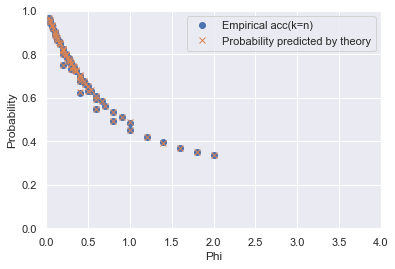

In [10]:
# PLOT
plt.plot(_phi, _pk, 'o', label='Empirical acc(k=n)')
#plt.plot(_phi, _approx, 'x', label='winner never moves')
plt.plot(_phi, _approx_walk, 'x', label='Probability predicted by theory')
#plt.plot([0, 3], [1, -2], '-', label='1 - phi')
plt.xlim((0, 4))
plt.ylim((0, 1))
plt.xlabel('Phi')
plt.ylabel('Probability')
plt.legend()
plt.show()

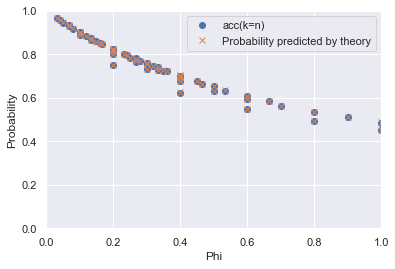

In [11]:
# ZOOM IN
plt.plot(_phi, _pk, 'o', label='acc(k=n)')
#plt.plot(_phi, _approx, 'x', label='winner never moves')
plt.plot(_phi, _approx_walk, 'x', label='Probability predicted by theory')
#plt.plot([0, 3], [1, -2], '-', label='1 - phi')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.xlabel('Phi')
plt.ylabel('Probability')
plt.legend()
plt.show()

# k* 

Empirical estimation of $k* = argmax ~ acc(k)$ as a function of $\phi$. 

$k*$ is the optimal argument of select-k-best such that the probability of selecting the winner is maximized.

In [12]:
# TO REMOVE
def approx_k_star_phi(phi):
    ''' Isabelle's final approximation.
    '''
    return 1 - (1 / np.log(phi))

####  Markov chain approach

For the random walk approach, we need to estimate:
- The probability of being in the top k (distance from origin < k after N steps)
- For each candidate, the probability of being in top k and the probability of being ranked first

acc(k) = P(true winner ranked first | true winner in top k) * p(true winner in top k)

Let's see the first part P(tw ranked first | tw in top k)
- For each element we compute P(in top k) * P(ranked first)
- For the true winner we have P(tw in top k) = approx_set_walk and P(tw ranked first) = acc(k=1)

If we make the (false) hypothesis that the events are indenpendents...

In [15]:
def approx_pk(n, N, k):
    ''' Approximation of P(k), the probability that the true winner is selected by select-k-best method.
    '''
    prior = proba_top_k(0, k, n, N) # P(true winner in top k)
    pk = proba_move(0, 0, n, N) # # P(k=1) = P(k=n) = proba of winner wining
    for e in range(1, n): # all other candidates
        # P(K) is increased when another candidate would win but is not in topk
        pk += (1 - proba_top_k(e, k, n, N)) * proba_move(e, 0, n, N)   
    return pk * prior

def approx_k_star(n, N):
    return np.argmax([approx_pk(n, N, k) for k in range(n)])

What is the behavior of $K*$ when $\phi$ varies?

#### Empirically

## BUG CORRECTION

Do not use `rk.select_k_best` here. This function looks at the scores and select the best performing candidate.
Here our list represents the ranking, so the k-best are the candidates on the left of the list!

In [83]:
def select_winner(topk, F):
    """ Return the first element from topk in F
    """
    for e in b:
        if e in a:
            return e

In [88]:
# Data points
_phi = [] # keep track of N/n ratio
_maxk = [] # keep track of k value
_maxpk = [] # estimated p(k)
_predicted_k_star = []
_approx_walk = [] # approximation of p(k) using random walks

# Parameters
trials = 200 #2500 #5000
_n = [20] #[5, 10, 15] #, 20, 25, 30]
_N = [10, 40, 180, 720] #[3, 6, 9, 12, 15] #[1, 2, 3, 4, 5] #, 6, 7, 8, 9, 10]

for n in tqdm(_n): # number of candidates
    for N in tqdm(_N):   # number of swaps
        _pk = []
        _k = []
        for k in range(1, n): # for select-k-best # begining at 1, at 2 ??? wtf here?
            # Artificial judges
            g = rk.generator.SwapGenerator()
            g.fit(list(range(n)))
            count = 0 # count when the true winner wins
            for _ in range(trials):
                # Compute the rank of the true winner
                D = g.sample(N=N, n=1)
                F = g.sample(N=N, n=1)
                # Select k best
                winner = select_winner(D[:k], F)
                #winner = rk.select_best(F[rk.select_k_best(D, k=k, reverse=True)], reverse=True)
                if winner == 0: # The selection went well
                    count += 1
            _pk.append(count / trials) # Estimated probability of selecting the true winner
            _k.append(k)
        _phi.append(N/n) # Noise factor
        k_star = _k[np.argmax(_pk)] # Empirical k*
        _maxk.append(k_star)
        _maxpk.append(np.max(_pk))
        predicted_k_star = approx_k_star(n, N)
        _predicted_k_star.append(predicted_k_star)
        _approx_walk.append(approx_pk(n, N, predicted_k_star))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [07:47<00:00, 467.80s/it]


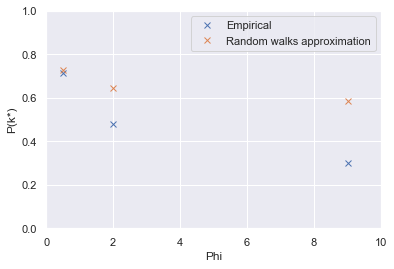

In [91]:
# acc(k*)
plt.plot(_phi, _maxpk, 'x', label='Empirical')
plt.plot(_phi, _approx_walk, 'x', label='Random walks approximation')
plt.xlim((0, 10))
plt.ylim((0, 1))
plt.xlabel('Phi')
plt.ylabel('P(k*)')
plt.legend()
plt.show()

acc(k\*) seems to be overestimated. Is empirical k\* and predicted k\* the same?

The difference may be explained by the fact that the predicted k\* is not the empirical k\* here... and we approximate acc(k\*) on the k\* given by the theory...

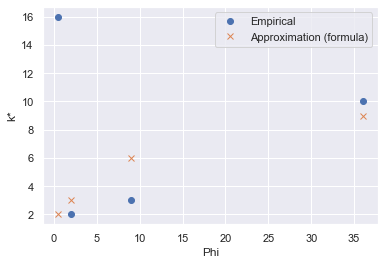

In [92]:
# K*
plt.plot(_phi, _maxk, 'o', label='Empirical')
#plt.plot(_phi, [approx_k_star_phi(phi) for phi in _phi], 'x', label="Isabelle's approximation")
plt.plot(_phi, _predicted_k_star, 'x', label="Approximation (formula)")
#plt.plot([0, 2], [2, 2], '-', color='grey', label='2')
plt.xlabel('Phi')
plt.ylabel('k*')
plt.legend()
plt.show()

### TODO

- Meta-training / meta-generalization curves for values of k ?
- Empirical always 2 ??? Strange

#### Estimation of $\phi = \frac{s}{n}$ on artificial data

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [01:04<00:00,  2.95it/s]


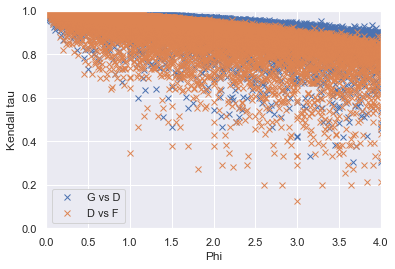

In [14]:
_phi = []
_corr = []
_corr_df = []
for n in tqdm(range(10, 200)):
    for N in range(0, 200):
        g = rk.generator.SwapGenerator()
        g.fit(n)
        _phi.append(N/n)
        _corr.append(rk.corr(g.sample(), g.sample(N=N), method='kendalltau'))
        _corr_df.append(rk.corr(g.sample(N=N), g.sample(N=N), method='kendalltau'))

# PLOT
plt.plot(_phi, _corr, 'x', label='G vs D')
plt.plot(_phi, _corr_df, 'x', label='D vs F')
plt.xlim((0, 4))
plt.ylim((0, 1))
plt.xlabel('Phi')
plt.ylabel('Kendall tau')
plt.legend()
plt.show()

n = 50


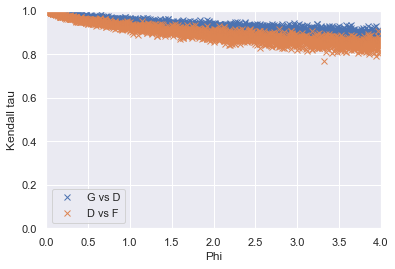

In [15]:
print('n = 50')
_phi = []
_corr = []
_corr_df = []
n = 50
for N in range(0, 200):
    for _ in range(10): # re-runs
        g = rk.generator.SwapGenerator()
        g.fit(n)
        _phi.append(N/n)
        _corr.append(rk.corr(g.sample(), g.sample(N=N), method='kendalltau'))
        _corr_df.append(rk.corr(g.sample(N=N), g.sample(N=N), method='kendalltau'))

# PLOT
plt.plot(_phi, _corr, 'x', label='G vs D')
plt.plot(_phi, _corr_df, 'x', label='D vs F')
plt.xlim((0, 4))
plt.ylim((0, 1))
plt.xlabel('Phi')
plt.ylabel('Kendall tau')
plt.legend()
plt.show()

In [20]:
import itertools

# diff between kendall tau correlation and distance ?
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html

def kendall_tau_distance(order_a, order_b):
    # TODO: add in Ranky
    pairs = itertools.combinations(range(0, len(order_a)), 2)
    distance = 0
    for x, y in pairs:
        a = order_a.index(x) - order_a.index(y)
        b = order_b.index(x) - order_b.index(y)
        if a * b < 0:
            distance += 1
    return distance

n = 50


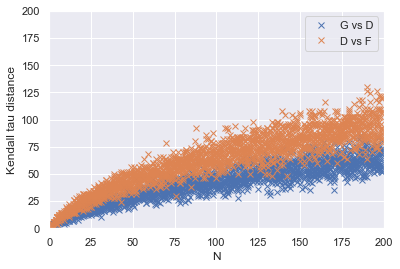

In [29]:
print('n = 50')
_phi = []
_corr = []
_corr_df = []
n = 50
_N = []
_log = []
for N in range(0, 200):
    for _ in range(10): # re-runs
        g = rk.generator.SwapGenerator()
        g.fit(n)
        _N.append(N)
        _corr.append(kendall_tau_distance(g.sample(), g.sample(N=N)))
        _corr_df.append(kendall_tau_distance(g.sample(N=N), g.sample(N=N)))

# PLOT
plt.plot(_N, _corr, 'x', label='G vs D')
plt.plot(_N, _corr_df, 'x', label='D vs F')
plt.xlim((0, 200))
plt.ylim((0, 200))
plt.xlabel('N')
plt.ylabel('Kendall tau distance')
plt.legend()
plt.show()

<a id='part2'></a>
### 2. One task case

##### Evaluate select-K-best on various 1 task problems

### TODO

- All datasets in one plot
- AutoDL benchmark data too (light version)
- Use the validation data instead of test for the development phase?
- Accuracy of selecting the post-challenge winner instead of score

In [76]:
path = 'data/automl_predictions'
reference = 'reference'
candidates = ['aad_freiburg', 'gaussian_nb_default', 'abhishek', 'jameslloyd',
              'rf_autosklearn', 'asml_intel', 'knn_autosklearn', 'rf_default',
              'baseline', 'knn_default', 'sgd_autosklearn', 'lise_sun', 'sgd_default', 'djajetic', 'marc_boulle', 'gaussian_nb_autosklearn']
# 'bayesian_ridge_default'
datasets = ['fabert'] #, 'adult', 'alexis', 'arturo', 'digits']
metric = 'accuracy'

In [7]:
!ls $path

aad_freiburg		 gaussian_nb_default	    reference
abhishek		 jameslloyd		    rf_autosklearn
asml_intel		 knn_autosklearn	    rf_default
baseline		 knn_default		    sgd_autosklearn
bayesian_ridge_default	 lise_sun		    sgd_default
djajetic		 marc_boulle
gaussian_nb_autosklearn  meta-ml_matrix_automl.zip


In [10]:
!ls $path/asml_intel

adult_test_001.predict	  digits_test_001.predict
adult_valid_001.predict   digits_valid_001.predict
alexis_test_005.predict   dilbert_test_001.predict
alexis_valid_005.predict  dilbert_valid_001.predict
arturo_test_001.predict   dorothea_test_001.predict
arturo_valid_001.predict  dorothea_valid_001.predict
cadata_test_001.predict   fabert_test_001.predict
cadata_valid_001.predict  fabert_valid_001.predict
carlo_test_001.predict	  newsgroups_test_005.predict
carlo_valid_001.predict   newsgroups_valid_005.predict


In [77]:
results = []
for dataset in tqdm(datasets):
    m1, m2, m3 = [], [], []
    ref_file = os.path.join(path, reference, dataset+'_test.solution')
    ref = pd.read_csv(ref_file, sep=" ", header=None)
    ref = ref.drop([ref.columns[-1]], axis=1) # fix problem in format
    # Development, Final and Post-challenge phases
    q = int(ref.shape[0]/4)
    ref1, ref2, ref3 = ref[:q], ref[q:2*q], ref[2*q:]
    for candidate in candidates:
        files = glob(os.path.join(path, candidate, dataset+'_test*.predict'))
        pred_file = sorted(files)[-1]
        pred = pd.read_csv(pred_file, sep=" ", header=None)
        pred = pred.drop([pred.columns[-1]], axis=1)
        pred1, pred2, pred3 = pred[:q], pred[q:2*q], pred[2*q:]
        
        s1, s2, s3 = rk.metric(ref1, pred1, method=metric), rk.metric(ref2, pred2, method=metric), rk.metric(ref3, pred3, method=metric)
        m1.append(s1)
        m2.append(s2)
        m3.append(s3)
    m1, m2, m3 = pd.Series(m1, index=candidates), pd.Series(m2, index=candidates), pd.Series(m3, index=candidates)
    results.append([m1, m2, m3])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.69it/s]


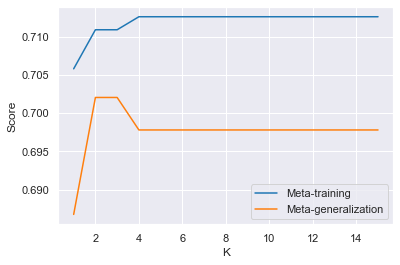

In [78]:
for result in results:
    mtr_scores = []
    mte_scores = []
    m1, m2, m3 = result
    x = range(1, len(m1))
    for k in x:
        mtr_scores.append(m2[rk.select_k_best(m1, k=k)].max())
        mte_scores.append(m3[rk.select_best(m2[rk.select_k_best(m1, k=k)])])
    plt.plot(x, mtr_scores, label='Meta-training', color='tab:blue')
    plt.plot(x, mte_scores, label='Meta-generalization', color='tab:orange')
plt.xlabel('K')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.show()

In [83]:
#rk.show(m1)
#rk.show(m2)
#rk.show(m3)

#### Estimation of $\phi = \frac{s}{n}$ on real data

Using Kendall distance?

<a id='part3'></a>
### 3. Multi-task (AutoML) case

### TODO

- Isabelle and Zhengying experiments to re-do
- Include many benchmarks

In [93]:
path = 'data/benchmarks'
data = pd.read_csv(os.path.join(path, 'AutoDL-AUC.data'), header=None, sep=' ')

In [94]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.779544,0.500000,0.517848,0.763679,0.775541,0.734880,0.826533,0.766728,0.526331,0.806690,0.777773,0.774149,0.737562
1,0.842297,0.845378,0.478315,0.838087,0.917024,0.917869,0.846077,0.923440,0.527739,0.865509,0.920989,0.582695,0.846415
2,0.972975,0.969119,0.492461,0.970853,0.986180,0.986808,0.972483,0.000000,0.499316,0.987100,0.924199,0.500735,0.971921
3,0.854215,0.845829,0.687706,0.881532,0.867467,0.839009,0.853844,0.854799,0.672484,0.852687,0.917105,0.836706,0.911055
4,0.969210,0.974283,0.554659,0.959138,0.986295,0.982435,0.976741,0.956886,0.603774,0.972017,0.991914,0.995511,0.965882
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.970493,0.995217,0.501476,0.982471,0.645388,0.995919,0.994895,0.991572,0.495117,0.994090,0.995958,0.981641,0.985026
62,0.983956,0.988829,0.512423,0.985829,0.000000,0.999574,0.983988,0.999699,0.497163,0.964100,0.999779,0.502423,0.987489
63,0.921112,0.937541,0.477854,0.918761,0.928910,0.936042,0.930368,0.924389,0.529446,0.923627,0.936274,0.490598,0.931946
64,0.899294,0.873962,0.500000,0.897626,0.918417,0.918029,0.887367,0.901292,0.499866,0.925562,0.910440,0.500000,0.887502


#### Estimation of $\phi = \frac{s}{n}$ on real data